# Measure and improve

How do we know that search engine's quality haven't deteriorated because of our changes? How do we know if cosine scoring is better than okapi scoring? How can we check if applying language models instead of vector-space models is beneficial? 

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. Normalized Discounted Cumulative Gain (NDCG)
3. 11-Point Interpolated Average
4. pFound

<!--We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.
-->

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.

## Data

There is a number of ways to evaluate a search engine, however, all of them require so called relevance judgements - human assigned scores of relevance between `(query, doc_id)` pairs. We will use Cranfield relevance judgements collection, download it from [GDrive](https://drive.google.com/drive/folders/1u6dSUqdrXsckSHmVHNNE27eDiajMWLl2?usp=sharing) or [GitHub](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/cranfield_data). 

This was the pioneering test collection in allowing precise quantitative measures of information retrieval effectiveness, but is nowadays too small for anything but the most elementary pilot experiments (which is exactly what we are doing here). Collected in the United Kingdom starting in the late 1950s, it contains 1400 abstracts of aerodynamics journal articles, a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.

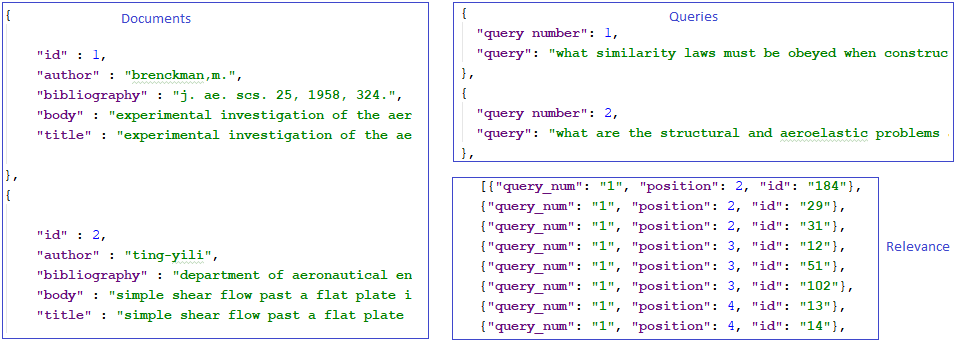


It comes in a json format, the detailed description is available in the readme file.

In [174]:
import json
from pathlib import Path
from collections import defaultdict

def read_cranfield(path):
    # TODO: read the cranfield data
    # relevance should be a dictionary, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    with open(path + "cranfield_data.json", "r") as f:
        documents = json.loads(f.read())
    with open(path + "cran.qry.json", "r") as f:
        queries = json.loads(f.read())
    with open(path + "cranqrel.json", "r") as f:
        relevance_data = json.loads(f.read())

    relevance = defaultdict(list)
    for query_info in relevance_data:
        query_id, score, doc_id = query_info["query_num"], query_info["position"], query_info["id"]
        relevance[int(query_id)].append((int(doc_id), int(score)))
        
    del queries[-1]
    return documents, queries, relevance

cran_orig_path = 'cranfield_data/'
documents, queries, relevance = read_cranfield(cran_orig_path)

### Test 

In [175]:
assert len(documents) == 1400 
assert len(relevance) == 225

## 1. Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top k documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). That is, if the set of relevant documents for an information need q<sub>j</sub> ∈ Q is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.


In [178]:
from statistics import mean

def mean_avg_precision(search_results, relevance):
    # TODO: calculate MAP score for search results, treating relevance judgments as binary - either relevant or not.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    average_precision = []
    for i, documents in enumerate(search_results):
        relevant_results = set([x[0] for x in relevance[i + 1]])
        prec = []
        relevant_docs = 0
        for j, doc in enumerate(documents):
            if doc in relevant_results:
                relevant_docs += 1
                prec += [relevant_docs / (j + 1)]
        average_precision += [mean(prec) if len(prec) > 0 else 0]
    return mean(average_precision)
    
    return 0

### 1.1 Test

In [179]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285715


## 2. 11-Point Interpolated Average

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def eleven_points_interpolated_avg(search_results, relevance, plot=True):
    def interp(pr, rec):
        i = 0
        while i < len(pr) and pr[i][0] < rec:
            i += 1
        if i == len(pr):
            return None

        sin_pr = 0
        for noth, current in pr[i:]:
            sin_pr = max(sin_pr, current)
        return sin_pr
    # TODO: return 11-points interpolated average over all queries. Refer to chapter 8.4 for explanation.
    # First calculate values of precision-recall curve for each query, interpolate them, and average over all queries.
    # This function is intended to use when for each query all documents are scored until the last relevant element
    # is met. Treats relevance judgments as binary - either relevant or not.
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    # return: interpolated_avg, list of 11 values    
    interpolated_avg = []

    # Making 11 placeholders for avg values
    for i in range(11):
        interpolated_avg.append([])

    for i in range(0, len(search_results)):

        relevant_results = set()
        for doc in relevance[i + 1]:
            relevant_results.add(doc[0])

        pr = []

        relevant_docs = 0
        for j in range(len(search_results[i])):
            if search_results[i][j] in relevant_results:
                relevant_docs += 1
            pr += [(relevant_docs / len(relevant_results), relevant_docs / (j + 1))]
        pr.sort()

        rec = 0
        for j in range(0, 11):
            tmp = interp(pr, rec)

            if tmp is not None:
                interpolated_avg[j].append(tmp)
            rec += 0.1

    for i in range(0, len(interpolated_avg)):
        interpolated_avg[i] = mean(interpolated_avg[i])

    if plot:
        X = np.linspace(0, 1, 11)
        plt.plot(X, interpolated_avg)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.show()

    return interpolated_avg

### 2.1.Test

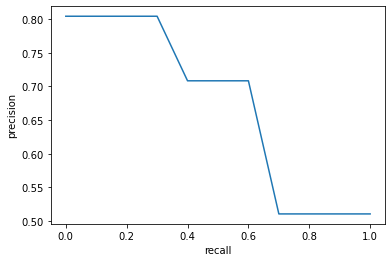

In [181]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 3. Normalized Discounted Cumulative Gain

There is also so called NDCG metric, which is designed for situations of non-binary notions of relevance. It is evaluated over some number *k* of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries Q, let *R(j,d)* be the relevance score assessors gave to document *d* for query *j*. Then,

![](https://i.imgur.com/LLogCYa.png)

where Z<sub>kj</sub> is a normalization factor calculated to make it so that a perfect ranking’s NDCG at *k* for query *j* is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [182]:
import math 

def NDCG(search_results, relevance):
    # TODO: compute NDCG score for search results. Here relevance is not considered as binary - the bigger
    # the judgement score is, the more relevant is the document to a query. Because in our cranfield dataset relevance
    # judgements are presented in a different way (1 is most relevant, 4 is least), we will need to smth with it. 
    # The simplest is to invert it, replacing each score with (5-score). For example, if the score was 2, it becomes 5-2=3.
    # To find normalization factor for each query, think in this direction - for this particular query what would be an
    # ideal DCG score? What documents should have (ideally) been returned by the search engine to maximize the DCG score?
    # When you find it, just normalize the real DCG score by ideal DCG score, that's it.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    average_precision = []
    for i in range(0, len(search_results)):
        relevant_results = dict(relevance[i + 1])

        dsg = 0
        for j in range(0, len(search_results[i])):

            tmp_doc = search_results[i][j]
            if tmp_doc in relevant_results:
                r = 5 - relevant_results[tmp_doc]
                dsg += (math.pow(2, r) - 1) / math.log2(j + 2)

        results = set(search_results[i])
        for doc in relevant_results.keys():
            results.add(doc)

        results = list(results)
        results.sort(key=lambda doc: 5 - relevant_results[doc] if doc in relevant_results else 0, reverse=True)

        idsg = 0
        for j in range(0, len(results)):

            tmp_doc = results[j]
            if tmp_doc in relevant_results:
                r = 5 - relevant_results[tmp_doc]
                idsg += (math.pow(2, r) - 1) / math.log2(j + 2)

        average_precision += [dsg / idsg if idsg != 0 else 0]
    return mean(average_precision)


### 3.1 Test

In [183]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

ndcg_test 0.6409675295633276


## 4. pFound ##
**pFound** -- ranking metric invented in [Yandex](http://romip.ru/romip2009/15_yandex.pdf). This metric models user behaviour when looking at the search engine representation page (SERP). Metric assumes a user is inspecting a list from the top to the bottom. There are 2 global parameters, controlling behaviour:
- `pBreak` -- how probable, that the user will become tired and just quit at this position (`0.15` by default).
- `pRel` -- how probable the user will click the document if this document is relevant (`0.4` by default for a relevan document, `0` is given to irrelevant).

Then, to compute pFound for the exact page we do:

$pLook_i = pLook_{i-1}*(1 - pBreak)*(1 - pRel_{i-1})$

$pFound = \sum_{i=1}^{N}pLook_i*pRel_i$

Implement `pFound` below.

In [184]:
import math 

def pFound(search_results, relevance, pBreak=0.15, pRel=0.4):
    # TODO: calculate pFound score for search results, treating relevance judgments as binary - either relevant or not
    
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    
    pFound_list = []
    for query_id, search_list in enumerate(search_results):
        relevant_docs = set([x[0] for x in relevance[query_id + 1]])
        
        pLook_list = []
        pRel_list = []
        pFound = 0
        for i, doc_id in enumerate(search_list):
            pLook_list.append(pLook_list[-1]*(1 - pBreak)*(1 - pRel_list[-1]) if pLook_list else 1)
            
            pRel_list.append(pRel if doc_id in relevant_docs else 0)
            
            pFound += pLook_list[i] * pRel_list[i]
        pFound_list.append(pFound)
        
    return mean(pFound_list)

## 5. Evaluation

Now we want to apply these metrics to some simple but real search engine. Print out all metrics you've just implemented for your search engine.

### Simpliest possible search engine

In [185]:
# this is the simplest possible search engine ever. Use it, or implement your own

def search(query, documents):
    query = query.split()
    result = []
    for doc in documents:
        # empty query is not interesting
        if len(query) == 0: continue
        # match score, from 0 to 1
        p = 0.0
        # on each word match from query -- increase the score
        for q in query:
            if q in doc['body'].lower() or q in doc['title'].lower(): 
                p += 1. / len(query)
        # include on non-0 match
        if p > 0.0:
            result.append((1 - p, doc['id']))

    # return top 50
    return [x[1] for x in sorted(result)][:50]

In [186]:
# TODO: write your code here
search_engine_results = [search(x["query"], documents) for x in queries]

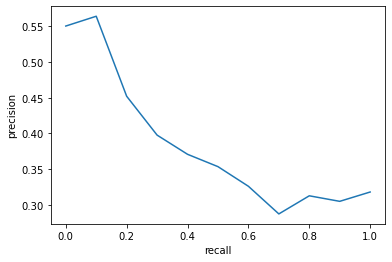

map_test 0.34751364626795955
ndcg_test 0.35358069280411764
pf_test 0.35553663160045323


In [191]:
eleven_test = eleven_points_interpolated_avg(search_engine_results, relevance, plot=True)
map_test = mean_avg_precision(search_engine_results, relevance)
print("map_test", map_test)
ndcg_test = NDCG(search_engine_results, relevance)
print("ndcg_test", ndcg_test)
pf_test = pFound(search_engine_results, relevance)
print("pf_test", pf_test)